In [3]:
import pandas as pd

# Paths
real_file = "/home/nikki/egfr_lowdata_scoring/data/features_real.csv"
synth_file = "/home/nikki/egfr_lowdata_scoring/data/features_synth.csv"

# Load
real_df = pd.read_csv(real_file)
synth_df = pd.read_csv(synth_file)

# Define label column
label_col = "label"

# Optional: drop rows with missing docking_score if using F2/F3
real_df = real_df.dropna(subset=["docking_score"])
synth_df = synth_df.dropna(subset=["docking_score"])


In [4]:
# Descriptor columns
desc_cols = ["MW", "LogP", "HBD", "HBA", "TPSA"]

# Fingerprint columns
fp_cols = [f"fp_{i}" for i in range(1024)]

# Docking column
dock_col = ["docking_score"]

# Feature sets
feature_sets = {
    "F1": desc_cols + fp_cols,              # descriptors + fingerprints
    "F2": dock_col,                         # docking only
    "F3": desc_cols + fp_cols + dock_col    # descriptors + fingerprints + docking
}


In [5]:
# Define pseudo-labels for synthetic
synth_df["pseudo_label"] = -1  # default, will drop ambiguous
synth_df.loc[synth_df["docking_score"] <= -9.0, "pseudo_label"] = 1
synth_df.loc[synth_df["docking_score"] >= -7.0, "pseudo_label"] = 0

# Keep only pseudo-labeled
synth_df = synth_df[synth_df["pseudo_label"] != -1]


In [6]:
from sklearn.model_selection import train_test_split

X_real = real_df
y_real = real_df[label_col]

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)


In [10]:
import pip
!pip install xgboost

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import xgboost as xgb


models = {
    "LR": LogisticRegression(max_iter=1000),
    "RF": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGB": xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric="logloss")
}


In [8]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

results = []

for m_name, model in models.items():
    for f_name, f_cols in feature_sets.items():
        for regime in ["R", "RS"]:
            
            # Prepare training data
            if regime == "R":
                X_train = X_real_train[f_cols]
                y_train = y_real_train
            elif regime == "RS":
                # Combine real + pseudo-labeled synthetic
                X_synth_train = synth_df[f_cols]
                y_synth_train = synth_df["pseudo_label"]
                
                X_train = pd.concat([X_real_train[f_cols], X_synth_train], axis=0)
                y_train = pd.concat([y_real_train, y_synth_train], axis=0)
            
            # Prepare test data (always real test)
            X_test = X_real_test[f_cols]
            y_test = y_real_test
            
            # Train
            model.fit(X_train, y_train)
            
            # Predict
            y_pred_prob = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)
            
            # Metrics
            roc = roc_auc_score(y_test, y_pred_prob)
            pr = average_precision_score(y_test, y_pred_prob)
            acc = accuracy_score(y_test, y_pred)
            
            results.append({
                "model": m_name,
                "features": f_name,
                "regime": regime,
                "ROC-AUC": roc,
                "PR-AUC": pr,
                "Accuracy": acc
            })
            
# Convert to DataFrame for easy view
results_df = pd.DataFrame(results)
print(results_df)


   model features regime   ROC-AUC    PR-AUC  Accuracy
0     LR       F1      R  1.000000  1.000000     1.000
1     LR       F1     RS  1.000000  1.000000     1.000
2     LR       F2      R  0.533333  0.659524     0.625
3     LR       F2     RS  0.533333  0.659524     0.625
4     LR       F3      R  1.000000  1.000000     1.000
5     LR       F3     RS  1.000000  1.000000     0.875
6     RF       F1      R  1.000000  1.000000     1.000
7     RF       F1     RS  1.000000  1.000000     0.875
8     RF       F2      R  0.833333  0.902857     0.625
9     RF       F2     RS  0.600000  0.659524     0.625
10    RF       F3      R  1.000000  1.000000     1.000
11    RF       F3     RS  1.000000  1.000000     0.875
12   XGB       F1      R  1.000000  1.000000     0.875
13   XGB       F1     RS  1.000000  1.000000     1.000
14   XGB       F2      R  0.733333  0.810000     0.500
15   XGB       F2     RS  0.500000  0.629524     0.375
16   XGB       F3      R  1.000000  1.000000     0.875
17   XGB  

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

# Function to compute enrichment in top k%
def enrichment_topk(y_true, y_pred_prob, top_frac=0.1):
    """
    Compute fraction of actives in top-k% predicted ligands.
    """
    n_top = max(1, int(len(y_pred_prob) * top_frac))  # at least 1
    # Sort by predicted probability descending
    idx_sorted = np.argsort(-y_pred_prob)
    top_idx = idx_sorted[:n_top]
    return y_true.iloc[top_idx].mean()  # fraction of actives

# Prepare metrics list
metrics_list = []

# Loop over all combinations
for m_name, model in models.items():
    for f_name, f_cols in feature_sets.items():
        for regime in ["R", "RS"]:
            
            # Prepare training data
            if regime == "R":
                X_train = X_real_train[f_cols]
                y_train = y_real_train
            elif regime == "RS":
                X_synth_train = synth_df[f_cols]
                y_synth_train = synth_df["pseudo_label"]
                X_train = pd.concat([X_real_train[f_cols], X_synth_train], axis=0)
                y_train = pd.concat([y_real_train, y_synth_train], axis=0)
            
            # Test data (always real test)
            X_test = X_real_test[f_cols]
            y_test = y_real_test
            
            # Train
            model.fit(X_train, y_train)
            
            # Predict
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)
            
            # Metrics
            roc = roc_auc_score(y_test, y_pred_prob)
            pr = average_precision_score(y_test, y_pred_prob)
            acc = accuracy_score(y_test, y_pred)
            enrich_top10 = enrichment_topk(y_test, y_pred_prob, top_frac=0.1)
            
            metrics_list.append({
                "model": m_name,
                "features": f_name,
                "regime": regime,
                "ROC-AUC": roc,
                "PR-AUC": pr,
                "Accuracy": acc,
                "Enrichment_top10%": enrich_top10
            })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Save results
metrics_df.to_csv("/home/nikki/egfr_lowdata_scoring/results/metrics_summary.csv", index=False)

print("Metrics saved to results/metrics_summary.csv")
print(metrics_df)


Metrics saved to results/metrics_summary.csv
   model features regime   ROC-AUC    PR-AUC  Accuracy  Enrichment_top10%
0     LR       F1      R  1.000000  1.000000     1.000                1.0
1     LR       F1     RS  1.000000  1.000000     1.000                1.0
2     LR       F2      R  0.533333  0.659524     0.625                0.0
3     LR       F2     RS  0.533333  0.659524     0.625                0.0
4     LR       F3      R  1.000000  1.000000     1.000                1.0
5     LR       F3     RS  1.000000  1.000000     0.875                1.0
6     RF       F1      R  1.000000  1.000000     1.000                1.0
7     RF       F1     RS  1.000000  1.000000     0.875                1.0
8     RF       F2      R  0.833333  0.902857     0.625                1.0
9     RF       F2     RS  0.600000  0.659524     0.625                1.0
10    RF       F3      R  1.000000  1.000000     1.000                1.0
11    RF       F3     RS  1.000000  1.000000     0.875             

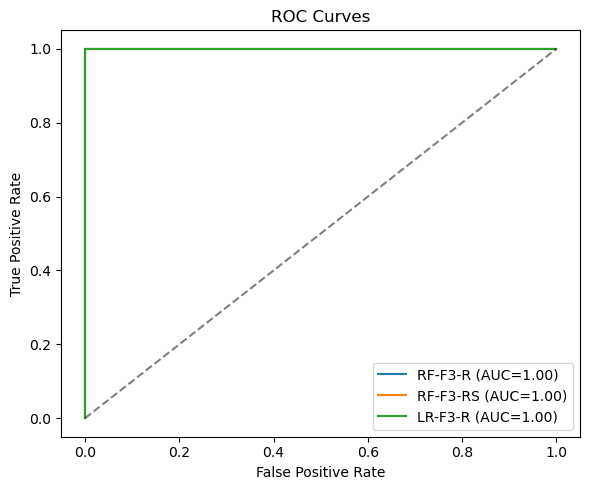

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
import numpy as np

# Select key models to plot
key_combinations = [
    {"model": "RF", "features": "F3", "regime": "R"},
    {"model": "RF", "features": "F3", "regime": "RS"},
    {"model": "LR", "features": "F3", "regime": "R"}
]

# Prepare a figure for ROC curves
plt.figure(figsize=(6,5))
for combo in key_combinations:
    m_name = combo["model"]
    f_name = combo["features"]
    regime = combo["regime"]
    
    # Prepare test data and features
    f_cols = feature_sets[f_name]
    X_test = X_real_test[f_cols]
    y_test = y_real_test
    
    # Train the model as before (R or RS)
    if regime == "R":
        X_train = X_real_train[f_cols]
        y_train = y_real_train
    else:  # RS
        X_synth_train = synth_df[f_cols]
        y_synth_train = synth_df["pseudo_label"]
        X_train = pd.concat([X_real_train[f_cols], X_synth_train], axis=0)
        y_train = pd.concat([y_real_train, y_synth_train], axis=0)
    
    # Fit model
    model = models[m_name]
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:,1]
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=f"{m_name}-{f_name}-{regime} (AUC={auc_val:.2f})")

plt.plot([0,1], [0,1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()


